<a href="https://colab.research.google.com/github/elena-vmartinez/Capstone-Project-Wikipedia-Time-Series-Prediction/blob/main/Wiki_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Tuple
import re
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import random
import tensorflow as tf

In [245]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [246]:
train = pd.read_csv("/content/train_1.csv")
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


Cleaning

In [247]:
# Drop null values
train.dropna(inplace=True)

# Reshape the DataFrame to have each row as an individual observation
train_flattened = pd.melt(
    train,
    id_vars='Page',
    var_name='date',
    value_name='visits'
)

In [249]:
# Using Date in row instead of column
train_flattened['date'] = pd.to_datetime(train_flattened['date'], errors='coerce')
train_flattened = train_flattened.sort_values(by=['date', 'Page'])

In [251]:
# Group by date to get total visits per day
daily_visits = train_flattened.groupby('date', as_index=False)['visits'].sum()

# Add a column to indicate if the date is a weekend (1) or a weekday (0)
daily_visits['weekend'] = (daily_visits['date'].dt.dayofweek // 5).astype(int)

# Changing visits from float to int
daily_visits['visits'] = daily_visits['visits'].astype(int)

# Add a column indicating the day of the week for each date
daily_visits['weekday'] = daily_visits['date'].dt.weekday

# Extract year, month, and day from the date
daily_visits['year'] = daily_visits['date'].dt.year
daily_visits['month'] = daily_visits['date'].dt.month
daily_visits['day'] = daily_visits['date'].dt.day

In [252]:
print(daily_visits.head())
print(daily_visits.shape)

        date     visits  weekend  weekday  year  month  day
0 2015-07-01  111535405        0        2  2015      7    1
1 2015-07-02  111653117        0        3  2015      7    2
2 2015-07-03  105858860        0        4  2015      7    3
3 2015-07-04  109797052        1        5  2015      7    4
4 2015-07-05  113380615        1        6  2015      7    5
(550, 7)


<Axes: ylabel='visits'>

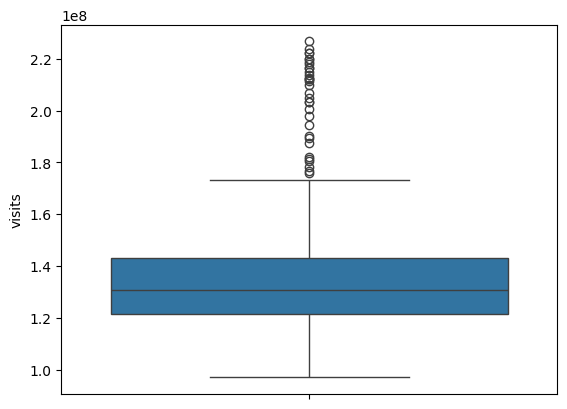

In [253]:
# Removing outliers
sns.boxplot(daily_visits['visits'])

<Axes: ylabel='visits'>

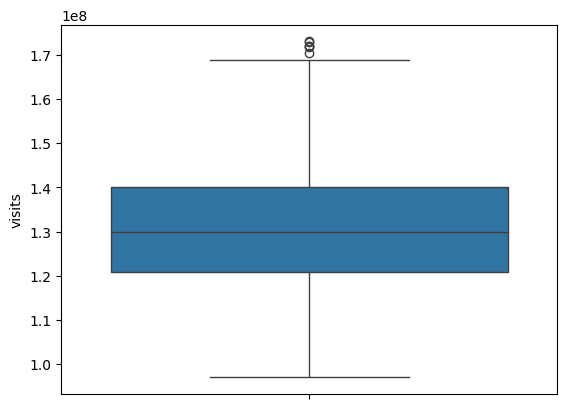

In [254]:
Q1 = daily_visits['visits'].quantile(0.25)
Q3 = daily_visits['visits'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_visits = daily_visits[daily_visits['visits'].between(lower_bound, upper_bound)]
sns.boxplot(daily_visits['visits'])

Exploration

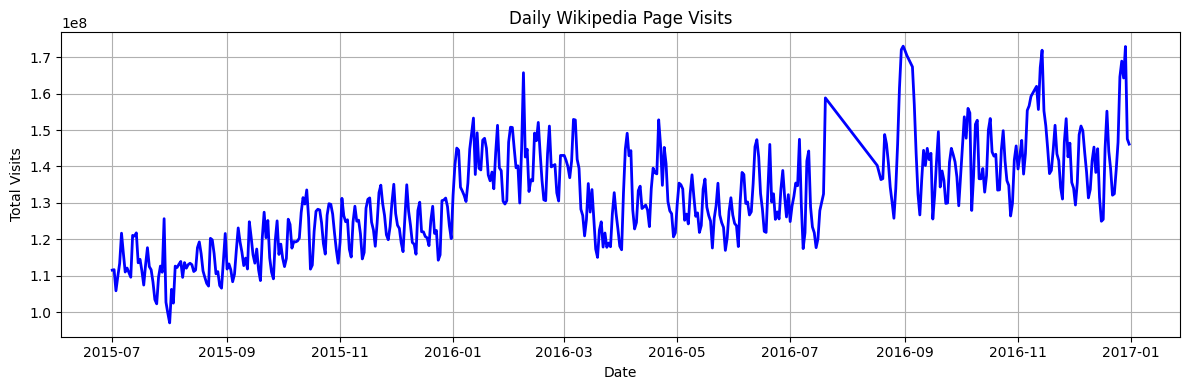

In [255]:
plt.figure(figsize=(12, 4))
plt.plot(daily_visits['date'], daily_visits['visits'], color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Visits')
plt.title('Daily Wikipedia Page Visits')
plt.grid(True)
plt.tight_layout()
plt.show()

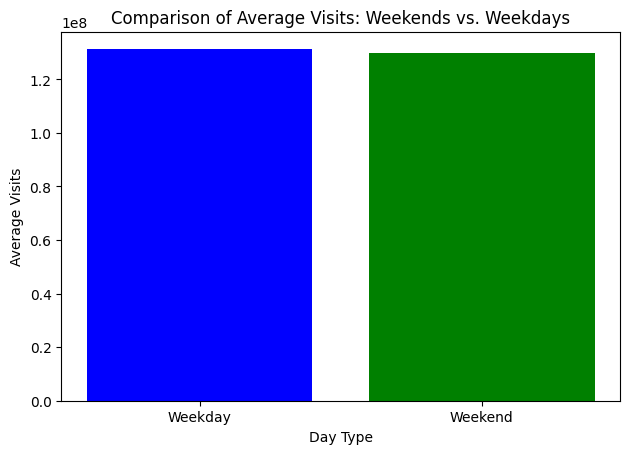

In [256]:
# Weekend Traffic VS Weekday Traffic

weekend_vs_weekday = daily_visits.groupby('weekend')['visits'].mean().reset_index()
weekend_vs_weekday.columns = ['Weekend', 'Average Visits']

weekend_vs_weekday['Weekend'] = weekend_vs_weekday['Weekend'].replace({0: 'Weekday', 1: 'Weekend'})

plt.bar(weekend_vs_weekday['Weekend'], weekend_vs_weekday['Average Visits'], color=['blue', 'green'])
plt.xlabel('Day Type')
plt.ylabel('Average Visits')
plt.title('Comparison of Average Visits: Weekends vs. Weekdays')
plt.tight_layout()
plt.show()

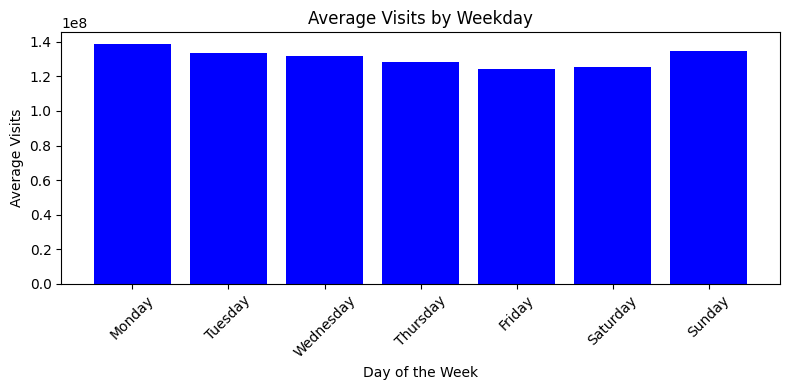

In [257]:
# Traffic by day of week

df0 = daily_visits.copy()

weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                   4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df0.loc[:, 'weekday_name'] = daily_visits['weekday'].map(weekday_mapping)

weekday_visits = df0.groupby('weekday_name')['visits'].mean().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_visits['weekday_name'] = pd.Categorical(weekday_visits['weekday_name'], categories=days_order, ordered=True)

weekday_visits = weekday_visits.sort_values('weekday_name')

plt.figure(figsize=(8, 4))
plt.bar(weekday_visits['weekday_name'], weekday_visits['visits'], color='blue')
plt.title('Average Visits by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Average Visits')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Model Prep

In [258]:
df = daily_visits.copy()
df.head()

,date,visits,weekend,weekday,year,month,day
0,2015-07-01,111535405,0,2,2015,7,1
1,2015-07-02,111653117,0,3,2015,7,2
2,2015-07-03,105858860,0,4,2015,7,3
3,2015-07-04,109797052,1,5,2015,7,4
4,2015-07-05,113380615,1,6,2015,7,5


In [259]:
df.shape

(517, 7)

In [260]:
# Lag features and rolling averages
df['visits_lag_1'] = df['visits'].shift(1)
df['visits_lag_7'] = df['visits'].shift(7)
df['rolling_avg_7'] = df['visits'].rolling(window=7).mean()

df.dropna(inplace=True) # since lags and averages won't apply to the start of the data

# Including numerical column "days_since_start", since some models won't handle datetime format
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Seasonal time-based split, at the end of Sept 2016 starting Oct 2016
split_date = '2016-10-01'
train_data = df[df['date'] < split_date]
test_data = df[df['date'] >= split_date]

X_train = train_data.drop(columns=['visits'])
y_train = train_data['visits']

X_test = test_data.drop(columns=['visits'])
y_test = test_data['visits']

# Without lag and rolling averages, just visits and day
df_basic = df[['date', 'visits']].copy()

train_basic = df_basic[df_basic['date'] < split_date]
test_basic = df_basic[df_basic['date'] >= split_date]

X_train_basic = train_basic[['date']]
y_train_basic = train_basic['visits']

X_test_basic = test_basic[['date']]
y_test_basic = test_basic['visits']

In [261]:
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")
print(train_data.head())
print(test_data.head())

Training data: (420, 11)
Test data: (90, 11)
         date     visits  weekend  weekday  year  month  day  visits_lag_1  \
7  2015-07-08  111014314        0        2  2015      7    8   116148499.0   
8  2015-07-09  112106318        0        3  2015      7    9   111014314.0   
9  2015-07-10  110875911        0        4  2015      7   10   112106318.0   
10 2015-07-11  109583154        1        5  2015      7   11   110875911.0   
11 2015-07-12  121076144        1        6  2015      7   12   109583154.0   

    visits_lag_7  rolling_avg_7  days_since_start  
7    111535405.0   1.127895e+08                 0  
8    111653117.0   1.128543e+08                 1  
9    105858860.0   1.135710e+08                 2  
10   109797052.0   1.135404e+08                 3  
11   113380615.0   1.146398e+08                 4  
          date     visits  weekend  weekday  year  month  day  visits_lag_1  \
458 2016-10-01  137370681        1        5  2016     10    1   129213453.0   
459 2016-10-02  

In [262]:
print(f"Training data: {train_basic.shape}")
print(f"Test data: {test_basic.shape}")
print(train_basic.head())
print(test_basic.head())

Training data: (420, 2)
Test data: (90, 2)
         date     visits
7  2015-07-08  111014314
8  2015-07-09  112106318
9  2015-07-10  110875911
10 2015-07-11  109583154
11 2015-07-12  121076144
          date     visits
458 2016-10-01  137370681
459 2016-10-02  145559330
460 2016-10-03  153639524
461 2016-10-04  147773057
462 2016-10-05  155958432


Experimenting with various models:

In [263]:
# Baseline
from sklearn.metrics import mean_squared_error

def naive_forecast(y_train, y_test):
  """ Creates Naive forecast, using only the previous value to insert as the next. """

  y_train_pred = y_train.shift(1).dropna() # shift creates the prediction for the next value based soley on the previous day
  y_test_pred = y_test.shift(1).dropna()

  y_train_aligned = y_train.loc[y_train_pred.index] # re-align
  y_test_aligned = y_test.loc[y_test_pred.index]

  return y_train_pred, y_train_aligned, y_test_pred, y_test_aligned

# Evaluating with RMSE

rmse_results = {}

def calculate_rmse(y_test, y_pred, model):
  """ Prints the Root Mean Squared Error (RMSE) of a given model. """
  rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
  print(f"RMSE for {model}: {rmse}")
  rmse_results[model] = rmse # store results in a dictionary

y_train_pred, y_train_aligned, y_test_pred, y_test_aligned = naive_forecast(y_train_basic, y_test_basic)
calculate_rmse(y_test_aligned, y_test_pred, "Naive Forecast")

RMSE for Naive Forecast: 8669513.51


In [264]:
# Linear Regression
X_train_no_datetime = train_data.drop(columns=['visits', 'date']) # dropping column with datetime format
X_test_no_datetime = test_data.drop(columns=['visits', 'date'])

lr_model = LinearRegression()
lr_model.fit(X_train_no_datetime, y_train)
y_pred = lr_model.predict(X_test_no_datetime)

calculate_rmse(y_test, y_pred, "Linear Regression")

RMSE for Linear Regression: 6727256.75


In [265]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    learning_rate=0.09,
    n_estimators=1000,
    max_depth=1,
    subsample=0.25,
    eval_metric="rmse",
    early_stopping_rounds=100,
)

xgb_model.fit(X_train_no_datetime, y_train, eval_set=[(X_test_no_datetime, y_test)], verbose=50)

y_pred = xgb_model.predict(X_test_no_datetime)
calculate_rmse(y_test, y_pred, "XGBoost")

[0]	validation_0-rmse:18480364.46474
[50]	validation_0-rmse:7460583.97122
[100]	validation_0-rmse:6824824.38328
[150]	validation_0-rmse:6814231.20385
[200]	validation_0-rmse:6670405.87997
[250]	validation_0-rmse:6620562.28546
[300]	validation_0-rmse:6723069.70686
[350]	validation_0-rmse:6617745.61862
[379]	validation_0-rmse:6631933.37625
RMSE for XGBoost: 6534806.33


In [266]:
# Keras, deep learning
model = Sequential()

model.add(Input(shape=(X_train_no_datetime.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')


model.fit(X_train_no_datetime, y_train, epochs=100, batch_size=32, validation_data=(X_test_no_datetime, y_test), verbose=1)
y_pred = model.predict(X_test_no_datetime)

calculate_rmse(y_test, y_pred, "Deep Learning Model")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 15168329840852992.0000 - val_loss: 13755528266121216.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9314506312253440.0000 - val_loss: 5982935077355520.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3431874290515968.0000 - val_loss: 815918024228864.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 310174015291392.0000 - val_loss: 172536050483200.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 156379658584064.0000 - val_loss: 72132079910912.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47190034612224.0000 - val_loss: 82631412678656.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47508008992768.0000 - val_loss: 62305609973760.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42996393312256.0000 - val_loss: 61745578115072.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40880761208832.0000 - val_loss: 6203

In [267]:
print(rmse_results)

{'Naive Forecast': 8669513.51, 'Linear Regression': 6727256.75, 'XGBoost': 6534806.33, 'Deep Learning Model': 7529817.29}
